# ISSR Prediction Models

## Imports

In [81]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from imblearn.under_sampling import RandomUnderSampler
import keras_tuner as kt
from joblib import Parallel, delayed
from tensorflow.keras.optimizers import Adam

## Load Dataset

In [4]:
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo_issr2021.csv")

In [5]:
data.head()

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
0,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:00,33.62,274.05,353.44,0.727,no,1-1,0.25,0.0,0.0
1,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:01,33.62,274.05,363.64,0.727,no,1-1,0.25,0.0,0.0
2,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:25,32.00,273.15,763.30,0.740,no,1-1,0.25,0.0,0.0
3,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:04,28.76,271.35,1507.31,0.737,no,1-1,0.25,0.0,0.0
4,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:58,24.08,268.75,2498.86,0.859,no,1-1,0.25,0.0,0.0


## Filter to 2022 and 2023

In [6]:
df = data[(data['year'] >= 2022) & (data['year'] <= 2023) & (data['press'] != -9999)]

## Preprocessing

### Convert issc from characters to integers

In [7]:
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [8]:
df

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
133,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:00,40.28,277.75,786.48,0.908,0,1-1,0.25,0.0,0.0
134,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:18,40.46,277.85,1168.85,0.882,0,1-1,0.25,0.0,0.0
135,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:27,41.36,278.35,1332.83,0.781,0,1-1,0.25,0.0,0.0
136,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:29,41.54,278.45,1372.03,0.784,0,1-1,0.25,0.0,0.0
137,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:01:10,37.94,276.45,2135.52,0.952,0,1-1,0.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332167,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:43:58,-59.44,222.35,40837.02,0.023,0,12-31,0.25,0.0,0.0
332168,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:12,-61.78,221.05,41838.00,0.025,0,12-31,0.25,0.0,0.0
332169,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:53,-63.22,220.25,42393.97,0.026,0,12-31,0.25,0.0,0.0
332170,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:45:55,-63.22,220.25,42417.66,0.026,0,12-31,0.25,0.0,0.0


## Classification Model

### Creating X and Y variables

In [9]:
X = df[['month', 'day', 'hour', 'etime', 'press', 'temp_f', 'press_alt', 'rh_ice', 'dpdp', 'volume']]
y = df['issc']

### Undersample as there is an imbalance in yes and no for issc

In [10]:
rus = RandomUnderSampler(random_state=42)

In [11]:
X_resampled, y_resampled = rus.fit_resample(X, y)

### Split the dataset into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [13]:
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit to logistic regression model

In [14]:
model = LogisticRegression()
model.fit(X_trained_scaled, y_train)

LogisticRegression()

In [15]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9871794871794872


In [16]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[76,  2],
       [ 0, 78]], dtype=int64)

In [17]:
data = pd.concat([X, y], axis = 1)

<Axes: >

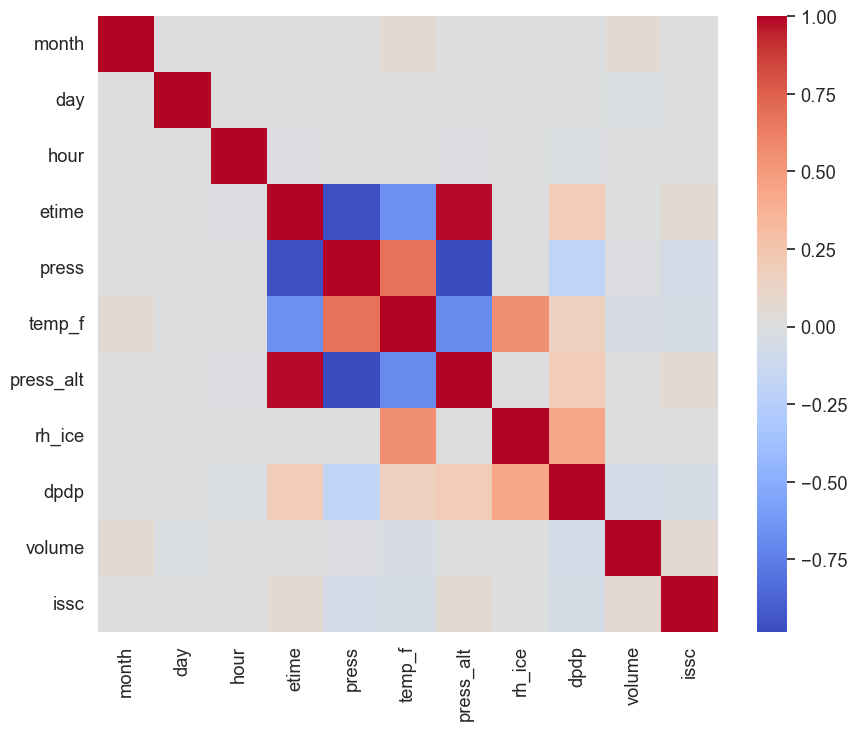

In [67]:
# Plot correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) 

sns.heatmap(data.corr(), fmt='.2f', cmap='coolwarm')

## Time Series Modeling

In [19]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
temp_count = df[df['temp_f'] < -42].groupby(df['date'].dt.date).size()
rh_ice_count = df[df['rh_ice'] > 1].groupby(df['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'volume'
temp_count.name = 'temp_volume'
rh_ice_count.name = 'rhi_volume'

df2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df3 = pd.merge(df2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df = pd.merge(df3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)


In [20]:
new_df

,volume,temp_volume,rhi_volume
2022-01-01,0.0,54.0,0.0
2022-01-02,1.0,52.0,20.0
2022-01-03,0.0,46.0,3.0
2022-01-04,0.0,68.0,3.0
2022-01-05,0.0,57.0,0.0
...,...,...,...
2023-12-27,1.0,71.0,1.0
2023-12-28,0.0,51.0,2.0
2023-12-29,0.0,61.0,6.0
2023-12-30,3.0,81.0,25.0


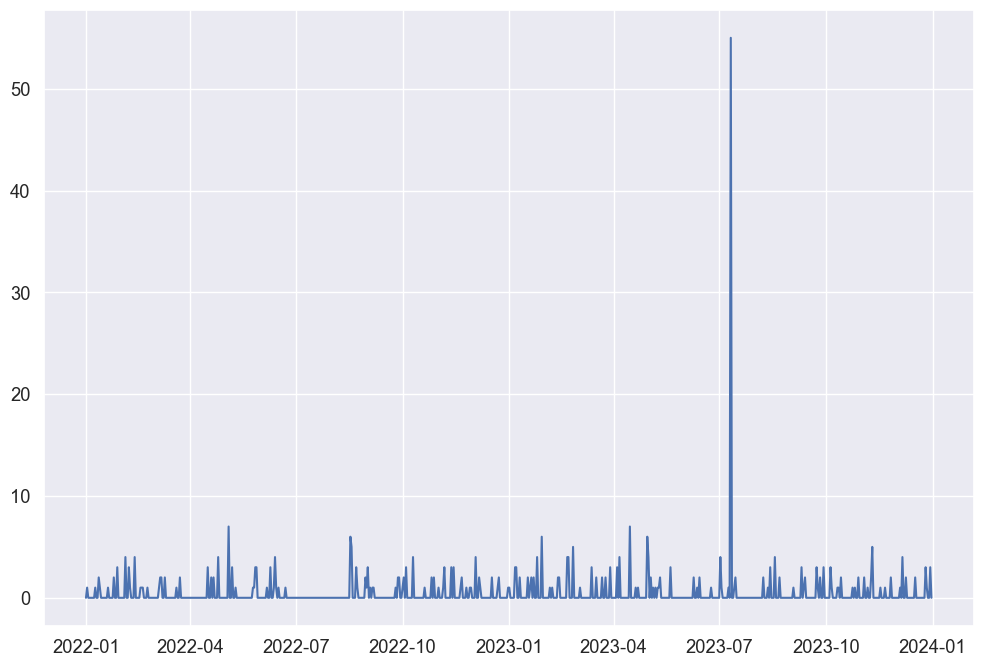

In [21]:
plt.figure(figsize = (12, 8))
plt.plot(new_df['volume'])

Analysis: There is a large outlier on July 11, 2023. This needs to be removed to output a more accurate time series model. 

## Autoregressive Integrated Moving Average (ARIMA) Model

In [22]:
new_df.drop('2023-07-11', inplace = True)

In [23]:
#Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp
#ARIMA is statistical analysis model that uses time series data to predict future trends. This model can predict
#future values based on past values. ARIMA parameters include:
#p: the number of lag observations in the model
#d: the number of times the raw observations are differenced
#q: the size of the moving average window
#The ARIMA model identifies the appropriate number of lags.

#Splitting Training and Testing set
train_size = int(0.8 * len(new_df))
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

# Fit ARIMA model
#Order represents, p, d, q. 
model = ARIMA(train['volume'], order=(3,1,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [24]:
#Root Mean Squared Error is used to evaluate the model. RMSE takes the square root fo the average of the squared
#differences between the predicted values and the actual values.The lower the RMSE, the more accurate the model.
mse = mean_squared_error(test['volume'], predictions)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.9892988981850243


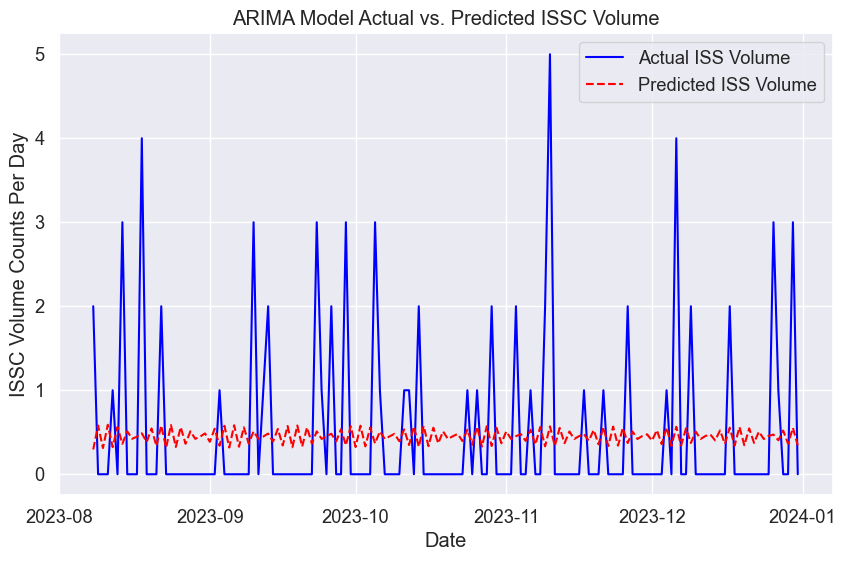

In [25]:
#Plotting Predicted versus Actual ISSC Volume Per Day
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
plt.plot(test.index, predictions, label='Predicted ISS Volume', color='red', linestyle='--')
plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.legend()
plt.grid(True)
plt.show()

Analysis: First attempt at ARIMA did not yield great results. Need to try different parameters.

### ARIMA Parameter Tuning

In [26]:
#Assign ARIMA Paramters
#Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
#Source: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d_values = range(0,3)
q_values = range(0,3)

In [27]:
#Function that evaluates the ARIMA Model

def eval_arima_model(train, test, p_values, d_values, q_values):
    #Save best mse score, best parameters, and predictions made
    best_score, best_param, predict = float("inf"), None, float("inf")
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train['volume'], order=(p, d, q))
                    model_fit = model.fit()
                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))
                    mse = (mean_squared_error(test['volume'], predictions))
                    print("The parameters p:", p, ", d:", d, ", q:", q, ". MSE =", mse)
                    #If mse is lower than the current best mse score, add that as the new mse
                    if mse < best_score:
                        best_score, best_param, predict = mse, order, predictions
                except:
                    continue
    print("Best ARIMA MSE Score =", best_score, best_param)
    
    #Plotting Predicted versus Actual ISSC Volume Per Day
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
    plt.plot(test.index, predict, label='Predicted ISS Volume', color='red', linestyle='--')
    plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
    plt.xlabel('Date')
    plt.ylabel('ISSC Volume Counts Per Day')
    plt.legend()
    plt.grid(True)
    plt.show()

The parameters p: 0 , d: 0 , q: 0 . MSE = 0.9901070856942309
The parameters p: 0 , d: 0 , q: 1 . MSE = 0.9906419135530118
The parameters p: 0 , d: 0 , q: 2 . MSE = 0.9902975906236035
The parameters p: 0 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 1 , q: 1 . MSE = 0.9901068046001588
The parameters p: 0 , d: 1 , q: 2 . MSE = 0.9906577422211205
The parameters p: 0 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 2 , q: 1 . MSE = 1.2191900220490832
The parameters p: 0 , d: 2 , q: 2 . MSE = 2.1884510809176247
The parameters p: 1 , d: 0 , q: 0 . MSE = 0.9906009780174189
The parameters p: 1 , d: 0 , q: 1 . MSE = 0.990555337869599
The parameters p: 1 , d: 0 , q: 2 . MSE = 0.9903062069540742
The parameters p: 1 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 1 , q: 1 . MSE = 0.9906188259832365
The parameters p: 1 , d: 1 , q: 2 . MSE = 0.9949001692532466
The parameters p: 1 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 

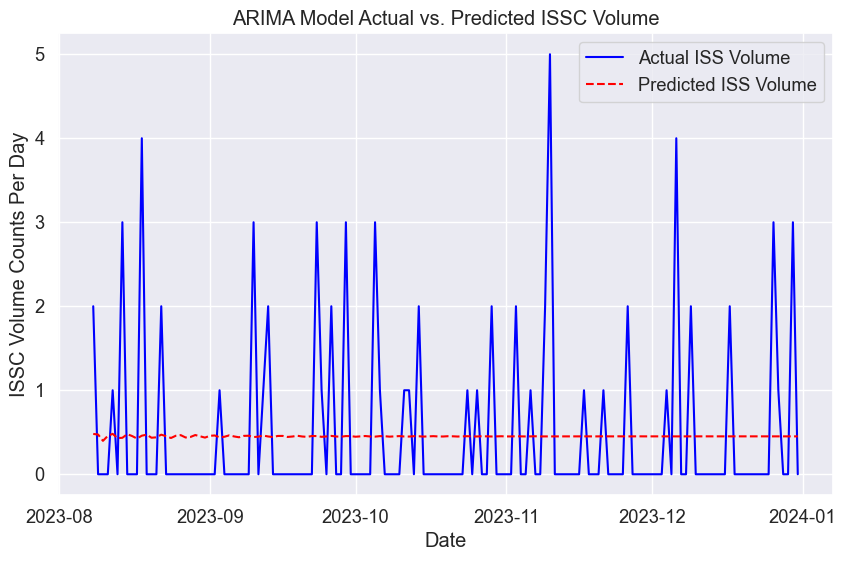

In [28]:
#Call function
eval_arima_model(train, test, p_values, d_values, q_values)

## Long Short Term Memory (LSTM)

### LSTM with Removing Outlier

In [30]:
#Removing outlier
outlier_df = new_df[new_df.index != '2023-07-11']

In [95]:
outlier_df

,volume,temp_volume,rhi_volume
2022-01-01,0.0,54.0,0.0
2022-01-02,1.0,52.0,20.0
2022-01-03,0.0,46.0,3.0
2022-01-04,0.0,68.0,3.0
2022-01-05,0.0,57.0,0.0
...,...,...,...
2023-12-27,1.0,71.0,1.0
2023-12-28,0.0,51.0,2.0
2023-12-29,0.0,61.0,6.0
2023-12-30,3.0,81.0,25.0


In [32]:
lstm_df = outlier_df.copy()

### Evaluate optimal number of lag variables

In [35]:
#Evaluate optimal number of lag features for ISSC volume, Temp Volume, and RHI Volume
issc_lag = [0, 1, 2]
temp_lag = [0, 1, 2]
rhi_lag = [0, 1, 2]

search_results2 = []

def lag_evaluation(issc_lag, temp_lag, rhi_lag):
    lstm_df = outlier_df.copy()
    
    for i in range(1, issc_lag + 1):
        lstm_df[f'volume_lag{i}'] = lstm_df['volume'].shift(i)
        lstm_df[f'volume_lag{i}'].fillna(0, inplace = True)

    for i in range(1, temp_lag + 1):
        lstm_df[f'temp_volume_lag{i}'] = lstm_df['temp_volume'].shift(i)
        lstm_df[f'temp_volume_lag{i}'].fillna(0, inplace = True)

    for i in range(1, rhi_lag + 1):
        lstm_df[f'rhi_volume_lag{i}'] = lstm_df['rhi_volume'].shift(i)
        lstm_df[f'rhi_volume_lag{i}'].fillna(0, inplace = True)
    X3 = lstm_df.iloc[:, 1:]
    y3 = lstm_df['volume'].values
    
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
    
    model = Sequential([
        LSTM(units=50, activation='relu', input_shape=(X3_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    
    # Train the model
    model.fit(X3_train, y3_train, epochs=50, batch_size = 32, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X3_test)
    mse = mean_squared_error(y3_test, predictions)
    return mse


for vl in issc_lag:
    for tl in temp_lag:
        for rl in rhi_lag:
            mse = lag_evaluation(vl, tl, rl)
            search_results2.append((vl, tl, rl, mse))
            print(f"Units: {u}, Learning Rate: {lr}, Batch Size: {bs}, ISSC_Lag: {vl}, Temp_Lag: {tl}, RHI_Lag: {rl}, MSE: {mse}")

5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 0, MSE: 0.5523280856416232
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 1, MSE: 0.5855528857893503
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 0, RHI_Lag: 2, MSE: 0.5567259687763494
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 0, MSE: 0.610280247640924
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 1, MSE: 0.6370451211321737
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, ISSC_Lag: 0, Temp_Lag: 1, RHI_Lag: 2, MSE: 0.5992615174868381
5/5 [==============================

In [79]:
#Optimal number of lag variables
best_lag = min(search_results2, key=lambda x: x[3])
print(f"Optimal number of lag variables: ISSC Lag={best_lag[0]}, Temp Lag={best_lag[1]}, RHI Lag={best_lag[2]} with MSE={best_lag[3]}")

Optimal number of lag variables: ISSC Lag=2, Temp Lag=0, RHI Lag=1 with MSE=0.5373260427613626


In [40]:
outlier_df2 = outlier_df.copy()

### Based of optimal number of lag variables, add to dataframe

In [41]:
#Input the number of lag features

#Create loop to add lag features to dataframe
for i in range(1, 2 + 1):
    outlier_df2[f'volume_lag{i}'] = outlier_df2['volume'].shift(i)
    
# Fill missing values with 0
outlier_df2['volume_lag1'] = outlier_df2['volume_lag1'].fillna(0)
outlier_df2['volume_lag2'] = outlier_df2['volume_lag2'].fillna(0)

In [44]:
#for i in range(1, 0 + 1):
#    outlier_df2[f'temp_volume_lag{i}'] = outlier_df2['temp_volume'].shift(i)

#outlier_df2['temp_volume_lag1'] = outlier_df2['temp_volume_lag1'].fillna(0)
#outlier_df2['temp_volume_lag2'] = outlier_df2['temp_volume_lag2'].fillna(0)

In [46]:
for i in range(1, 1 + 1):
    outlier_df2[f'rhi_volume_lag{i}'] = outlier_df2['rhi_volume'].shift(i)

outlier_df2['rhi_volume_lag1'] = outlier_df2['rhi_volume_lag1'].fillna(0)
#outlier_df2['rhi_volume_lag2'] = outlier_df2['rhi_volume_lag2'].fillna(0)

In [47]:
outlier_df2

,volume,temp_volume,rhi_volume,volume_lag1,volume_lag2,rhi_volume_lag1
2022-01-01,0.0,54.0,0.0,0.0,0.0,0.0
2022-01-02,1.0,52.0,20.0,0.0,0.0,0.0
2022-01-03,0.0,46.0,3.0,1.0,0.0,20.0
2022-01-04,0.0,68.0,3.0,0.0,1.0,3.0
2022-01-05,0.0,57.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...
2023-12-27,1.0,71.0,1.0,3.0,0.0,9.0
2023-12-28,0.0,51.0,2.0,1.0,3.0,1.0
2023-12-29,0.0,61.0,6.0,0.0,1.0,2.0
2023-12-30,3.0,81.0,25.0,0.0,0.0,6.0


### Hyperparameter tuning

In [56]:
#trying to find optimal hyper parameters for LSTM model

# Define the grid of hyperparameters to search
units = [50, 100, 150]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Placeholder for storing the results
search_results = []

def build_and_evaluate_model(units, learning_rate, batch_size):
    # Build the model
    X4 = outlier_df2.iloc[:, 1:]
    y4 = outlier_df2['volume'].values

    X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
    
    model = Sequential([
        LSTM(units=units, activation='relu', input_shape=(X4_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Train the model
    model.fit(X4_train, y4_train, epochs=50, batch_size=batch_size, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X4_test)
    mse = mean_squared_error(y4_test, predictions)
    return mse

# Iterate over each combination of hyperparameters
for u in units:
    for lr in learning_rates:
        for bs in batch_sizes:
            mse = build_and_evaluate_model(u, lr, bs)
            search_results.append((u, lr, bs, mse))
            print(f"Units: {u}, Learning Rate: {lr}, Batch Size: {bs}, MSE: {mse}")

# Find the best hyperparameters
best_hyperparams = min(search_results, key=lambda x: x[3])
print(f"Best Hyperparameters: Units={best_hyperparams[0]}, Learning Rate={best_hyperparams[1]}, Batch Size={best_hyperparams[2]} with MSE={best_hyperparams[3]}")

5/5 [==============================] - 0s 3ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 16, MSE: 0.6470795349365975
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 32, MSE: 0.651649526856392
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.01, Batch Size: 64, MSE: 0.6277732125483461
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.001, Batch Size: 16, MSE: 0.5818601374747341
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.001, Batch Size: 32, MSE: 0.5908426255759163
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.001, Batch Size: 64, MSE: 0.5583878135158067
5/5 [==============================] - 0s 2ms/step
Units: 50, Learning Rate: 0.0001, Batch Size: 16, MSE: 0.5627513839247996
5/5 [==============================] - 0s 3ms/step
Units: 50, Learning Rate: 0.0001, Batch Size: 32, MSE: 0.5525647594229752
5/5 [=====

In [57]:
search_results

[(50, 0.01, 16, 0.6470795349365975),
 (50, 0.01, 32, 0.651649526856392),
 (50, 0.01, 64, 0.6277732125483461),
 (50, 0.001, 16, 0.5818601374747341),
 (50, 0.001, 32, 0.5908426255759163),
 (50, 0.001, 64, 0.5583878135158067),
 (50, 0.0001, 16, 0.5627513839247996),
 (50, 0.0001, 32, 0.5525647594229752),
 (50, 0.0001, 64, 0.540885586841852),
 (100, 0.01, 16, 0.6170125416164813),
 (100, 0.01, 32, 0.5733938447744011),
 (100, 0.01, 64, 0.5193983660770691),
 (100, 0.001, 16, 0.5876532207991285),
 (100, 0.001, 32, 0.5600388289511401),
 (100, 0.001, 64, 0.5652059340534836),
 (100, 0.0001, 16, 0.584096057684385),
 (100, 0.0001, 32, 0.5516073382646471),
 (100, 0.0001, 64, 0.5548974963974688),
 (150, 0.01, 16, 0.5464029876172928),
 (150, 0.01, 32, 0.5489342999977707),
 (150, 0.01, 64, 0.5645719032778515),
 (150, 0.001, 16, 0.5395694222052153),
 (150, 0.001, 32, 0.5572992301367168),
 (150, 0.001, 64, 0.545568856091589),
 (150, 0.0001, 16, 0.5683234202470161),
 (150, 0.0001, 32, 0.5593385276844337),


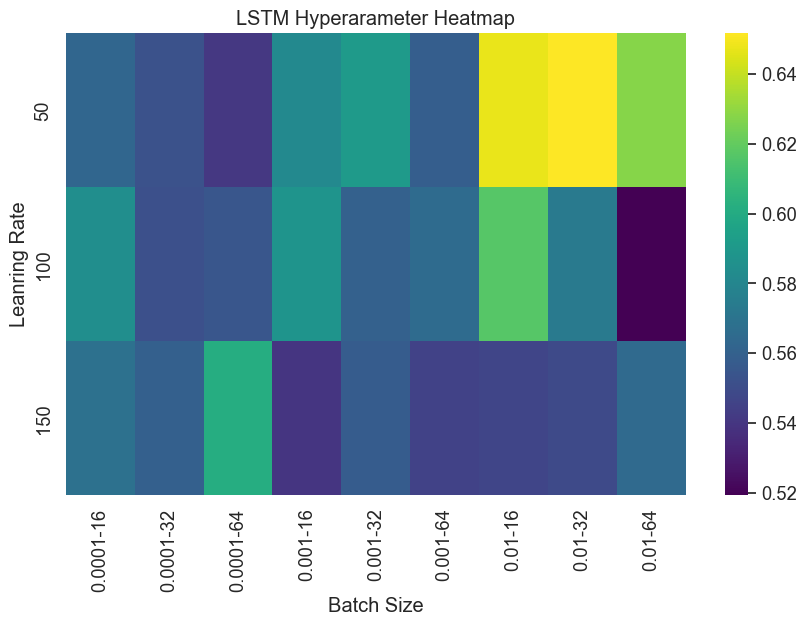

In [96]:
heatmap_df = pd.DataFrame(search_results, columns = ['Units', 'Learning Rate', 'Batch Size', 'MSE'])

pivot_df = heatmap_df.pivot_table(index='Units', columns=['Learning Rate', 'Batch Size'], values='MSE')

plt.figure(figsize = (10, 6))
sns.heatmap(pivot_df, cmap = 'viridis')

plt.title("LSTM Hyperarameter Heatmap")
plt.xlabel("Batch Size")
plt.ylabel('Leanring Rate')
plt.show()

### Most optimal number of lag variables and hyperparameters

In [73]:
# Model with optimal parameters from cell above
X5 = outlier_df2.iloc[:, 1:]
y5 = outlier_df2['volume'].values

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(units = 100, activation = 'relu', input_shape = (X5_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse')

model.fit(X5_train, y5_train, epochs = 50, batch_size = 64, validation_split = 0.2, verbose = 1)

test_loss = model.evaluate(X5_test, y5_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50
8/8 [==============================] - 2s 57ms/step - loss: 8.1320 - val_loss: 1.0378
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 1.1460 - val_loss: 0.9916
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 1.1028 - val_loss: 0.9438
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0571 - val_loss: 0.9166
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 1.0262 - val_loss: 0.9082
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 1.0213 - val_loss: 0.9158
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 1.0381 - val_loss: 1.0773
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.9945 - val_loss: 0.9286
Epoch 9/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9859 - val_loss: 0.9432
Epoch 10/50
8/8 [==============================] - 0s 10ms/step - loss: 1.0258 - val_loss: 0.9609
Epoch 11/50
8/8 [=============

23/23 [==============================] - 0s 2ms/step


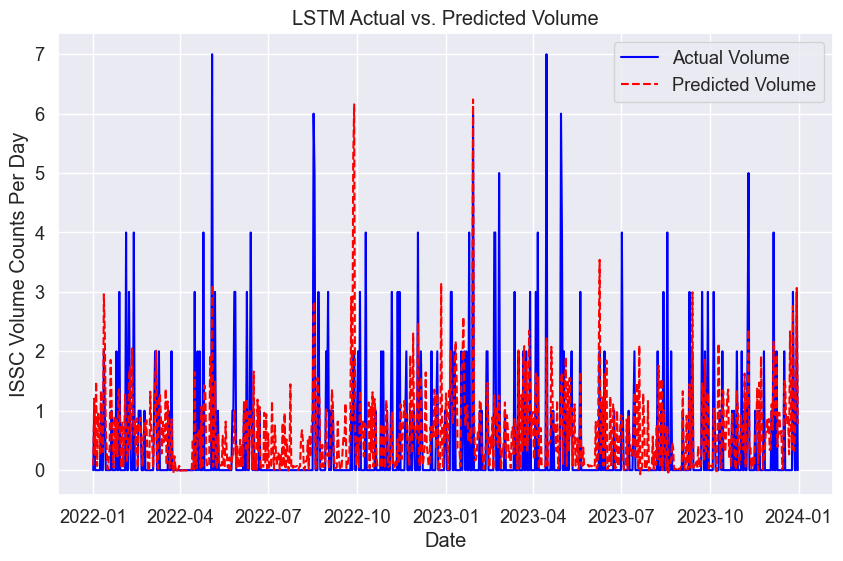

In [86]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = outlier_df2['volume']
predicted_volume = model.predict(X5)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.title('LSTM Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [78]:
latest_volume_lag12 = outlier_df2[['volume_lag1', 'volume_lag2', 'temp_volume', 'rhi_volume', 'rhi_volume_lag1']].iloc[-1]
# Reshape the input data
X_pred = np.array([latest_volume_lag12])
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make predictions
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 [==============================] - 0s 24ms/step
Predicted volume for 2024-01-01 00:00:00: 0.6217048
